# Project 2 - Used Car Price Estimation
### Team 5- Harsh, Hosang, Simran
Dataset: https://www.kaggle.com/datasets/avikasliwal/used-cars-price-prediction

### 1. Importing Libraries


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from fuzzywuzzy import process, fuzz

### 2. Loading the Data

In [81]:
# Load the dataset
file_path = '../data/Used_Car_Prices/train-data.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


### 3. Data Exploration


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


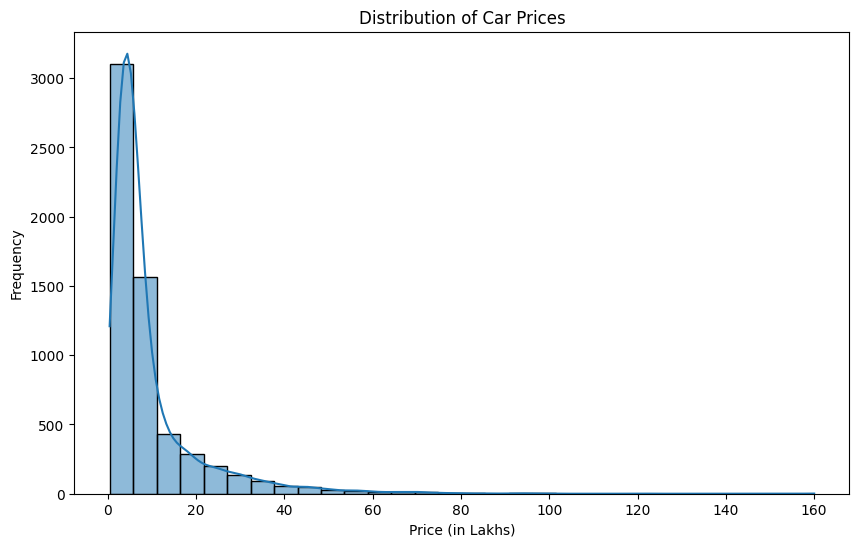

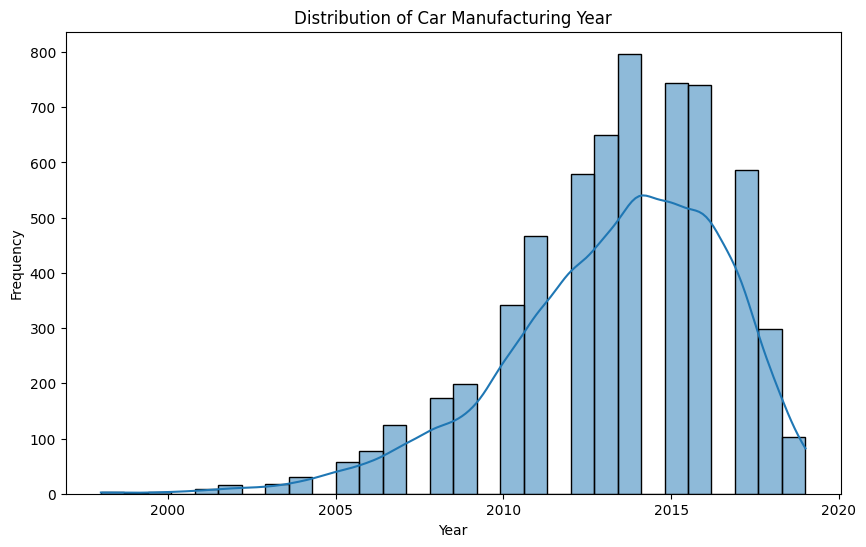

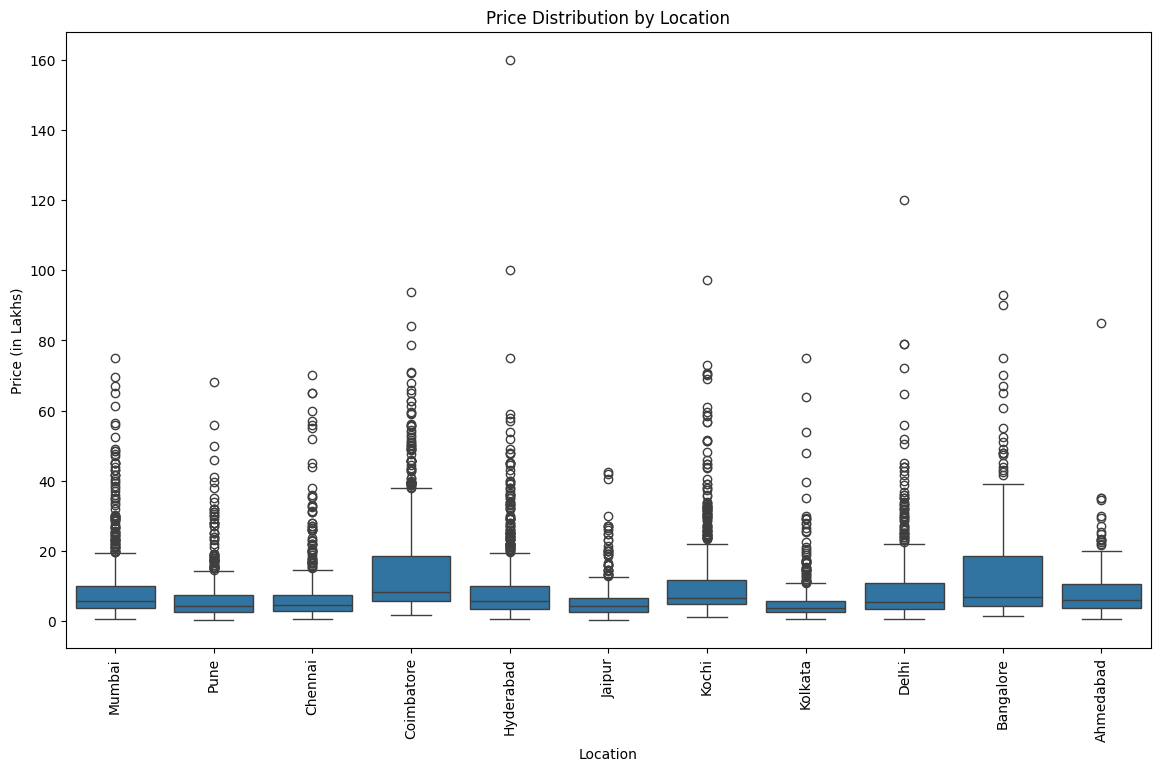

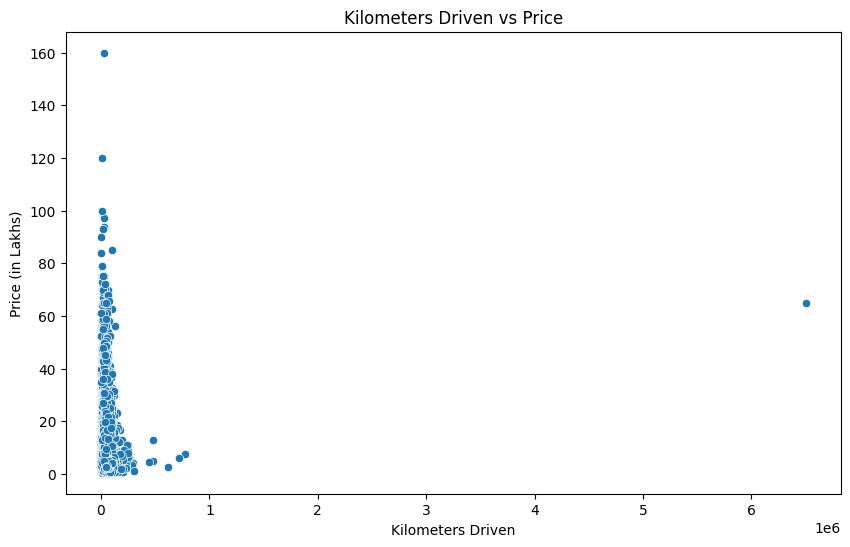

In [82]:
# Check for missing values
data.info()

# Summary statistics of the dataset
data.describe()

# Distribution of the target variable 'Price'
plt.figure(figsize=(10, 6))
sns.histplot(data['Price'], kde=True, bins=30)
plt.title('Distribution of Car Prices')
plt.xlabel('Price (in Lakhs)')
plt.ylabel('Frequency')
plt.show()

# Distribution of 'Year'
plt.figure(figsize=(10, 6))
sns.histplot(data['Year'], kde=True, bins=30)
plt.title('Distribution of Car Manufacturing Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show()

# Boxplot of 'Price' by 'Location'
plt.figure(figsize=(14, 8))
sns.boxplot(x='Location', y='Price', data=data)
plt.title('Price Distribution by Location')
plt.xlabel('Location')
plt.ylabel('Price (in Lakhs)')
plt.xticks(rotation=90)
plt.show()

# Scatter plot of 'Kilometers_Driven' vs 'Price'
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Kilometers_Driven', y='Price', data=data)
plt.title('Kilometers Driven vs Price')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price (in Lakhs)')
plt.show()

### 4. Data Preprocessing
#### 4.1 Convert 'New_Price' to Numerical Values

In [83]:
# Convert 'New_Price' to numerical values and convert 'Lakh' and 'Cr' to CAD
def convert_to_cad(price):
    if pd.isna(price):
        return price
    if 'Lakh' in price:
        return float(price.replace(' Lakh', '').replace(',', '')) * 100000 / 60  # Assuming 1 CAD = 60 INR
    elif 'Cr' in price:
        return float(price.replace(' Cr', '').replace(',', '')) * 10000000 / 60  # Assuming 1 CAD = 60 INR
    return np.nan

data['New_Price'] = data['New_Price'].apply(convert_to_cad)
data['Price'] = data['Price'] * 100000 / 60  # Convert 'Price' to CAD

# Ensure 'New_Price' is numerical
data['New_Price'] = pd.to_numeric(data['New_Price'], errors='coerce')

# Check the conversion result
print(data['New_Price'].head())

0        NaN
1        NaN
2    14350.0
3        NaN
4        NaN
Name: New_Price, dtype: float64


In [84]:
# Check the percentage of NaN values in 'New_Price' after conversion
new_price_missing_values = data['New_Price'].isnull().sum()
new_price_missing_percentage = (new_price_missing_values / len(data)) * 100
print("Missing values percentage for 'New_Price' after conversion:\n", new_price_missing_percentage)

Missing values percentage for 'New_Price' after conversion:
 86.31001827546105


#### 4.2 Simplifying the Model Names

In [85]:
# Simplify the model names by keeping the first few words
def simplify_model_name(name):
    return ' '.join(name.split()[:3])

data['Simplified_Name'] = data['Name'].apply(simplify_model_name)

# Check the unique simplified names
print(data['Simplified_Name'].unique())

['Maruti Wagon R' 'Hyundai Creta 1.6' 'Honda Jazz V' 'Maruti Ertiga VDI'
 'Audi A4 New' 'Hyundai EON LPG' 'Nissan Micra Diesel'
 'Toyota Innova Crysta' 'Volkswagen Vento Diesel' 'Tata Indica Vista'
 'Maruti Ciaz Zeta' 'Honda City 1.5' 'Maruti Swift VDI' 'Land Rover Range'
 'Land Rover Freelander' 'Mitsubishi Pajero Sport' 'Honda Amaze S'
 'Maruti Swift DDiS' 'Renault Duster 85PS' 'Mercedes-Benz New C-Class'
 'BMW 3 Series' 'Maruti S Cross' 'Audi A6 2011-2015' 'Hyundai i20 1.2'
 'Volkswagen Vento Petrol' 'Honda City Corporate' 'Maruti Alto K10'
 'Honda WRV i-VTEC' 'Toyota Innova 2.5' 'Renault Duster 110PS'
 'Toyota Corolla Altis' 'Mahindra Ssangyong Rexton' 'Audi A6 2.7'
 'Volkswagen Vento 1.6' 'Maruti Vitara Brezza' 'Mahindra KUV 100'
 'Mercedes-Benz M-Class ML' 'Volkswagen Polo Diesel' 'Maruti Alto LXi'
 'Tata Nano LX' 'Hyundai i20 Magna' 'Hyundai Elantra 2.0'
 'Hyundai Elantra CRDi' 'Hyundai Xcent 1.1' 'Mahindra Thar CRDe'
 'Audi A4 2.0' 'Maruti Swift LDI' 'Maruti Swift Ldi' 'Hyundai

#### 4.3 Filling Missing Values

In [86]:
# Create a copy of the data to use for filling missing values
data_copy = data.copy()

# Function to fill missing 'New_Price' using similar models
def fill_missing_new_price(row, data_copy):
    if pd.isna(row['New_Price']):
        # Get similar models using Simplified_Name
        similar_models = process.extract(row['Simplified_Name'], data_copy['Simplified_Name'].unique(), scorer=fuzz.token_sort_ratio, limit=5)
        # Get the median 'New_Price' from similar models
        similar_model_names = [model[0] for model in similar_models]
        similar_prices = data_copy[data_copy['Simplified_Name'].isin(similar_model_names)]['New_Price'].dropna()
        if not similar_prices.empty:
            return similar_prices.median()
    return row['New_Price']

# Apply the function to fill missing 'New_Price'
data['New_Price'] = data.apply(lambda row: fill_missing_new_price(row, data_copy), axis=1)

# Check the percentage of NaN values for 'New_Price' after filling
new_price_final_missing_values = data['New_Price'].isnull().sum()
new_price_final_missing_percentage = (new_price_final_missing_values / len(data)) * 100
print("Missing values percentage for 'New_Price' after filling:\n", new_price_final_missing_percentage)


Missing values percentage for 'New_Price' after filling:
 31.0350556570859


In [88]:
# Save the intermediate result to a CSV file
data.to_csv('../data/Used_Car_Prices/processed_data.csv', index=False)

In [4]:
# Load the intermediate result
data = pd.read_csv('../data/Used_Car_Prices/processed_data.csv')

#### 4.4 Convert Other Columns to Numerical Values

In [5]:
# Ensure 'New_Price' is numerical
data['New_Price'] = pd.to_numeric(data['New_Price'], errors='coerce')

# Convert relevant columns to strings first
data['Mileage'] = data['Mileage'].astype(str)
data['Engine'] = data['Engine'].astype(str)
data['Power'] = data['Power'].astype(str)

# Remove unwanted strings and convert to numeric types
data['Mileage'] = data['Mileage'].str.replace(' kmpl', '').str.replace(' km/kg', '').astype(float)
data['Engine'] = data['Engine'].str.replace(' CC', '').astype(float)
data['Power'] = data['Power'].str.replace(' bhp', '').replace('null', '0').astype(float)

data.head()


,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Simplified_Name
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.60,998.0,58.16,5.0,9233.333333,2916.666667,Maruti Wagon R
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67,1582.0,126.20,5.0,27266.666667,20833.333333,Hyundai Creta 1.6
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.20,1199.0,88.70,5.0,14350.000000,7500.000000,Honda Jazz V
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77,1248.0,88.76,7.0,18783.333333,10000.000000,Maruti Ertiga VDI
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.20,1968.0,140.80,5.0,92683.333333,29566.666667,Audi A4 New


#### 4.5 Dropping Remaining Rows with NaN Values

In [6]:
# Drop remaining rows with NaN values
data.dropna(inplace=True)

# Check the percentage of NaN values for all columns after processing
final_missing_values = data.isnull().sum()
final_missing_percentage = (final_missing_values / len(data)) * 100
print("Missing values percentage after processing all columns:\n", final_missing_percentage)

# Check the final number of rows and columns
print("Remaining data shape:", data.shape)

# Drop 'Unnamed: 0' column if it exists
if 'Unnamed: 0' in data.columns:
    data.drop('Unnamed: 0', axis=1, inplace=True)

Missing values percentage after processing all columns:
 Unnamed: 0           0.0
Name                 0.0
Location             0.0
Year                 0.0
Kilometers_Driven    0.0
Fuel_Type            0.0
Transmission         0.0
Owner_Type           0.0
Mileage              0.0
Engine               0.0
Power                0.0
Seats                0.0
New_Price            0.0
Price                0.0
Simplified_Name      0.0
dtype: float64
Remaining data shape: (4118, 15)


#### 4.5 Encoding Categorical Variables

In [7]:
# Encode categorical variables
label_encoder = LabelEncoder()

data['Location'] = label_encoder.fit_transform(data['Location'])
data['Fuel_Type'] = label_encoder.fit_transform(data['Fuel_Type'])
data['Transmission'] = label_encoder.fit_transform(data['Transmission'])
data['Owner_Type'] = label_encoder.fit_transform(data['Owner_Type'])
data['Name'] = label_encoder.fit_transform(data['Name'])

#### 4.6 Outlier Removal


In [8]:
# Define a function to remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from 'Price', 'Kilometers_Driven', 'Mileage', 'Engine', 'Power'
data = remove_outliers(data, 'Price')
data = remove_outliers(data, 'Kilometers_Driven')
data = remove_outliers(data, 'Mileage')
data = remove_outliers(data, 'Engine')
data = remove_outliers(data, 'Power')

### 5. Splitting the Data


In [9]:
# Drop the 'Simplified_Name' column
data = data.drop(columns=['Simplified_Name'])

# Define the feature set (X) and the target variable (y)
X = data.drop(columns=['Price'])  # Assuming 'Price' is the target variable
y = data['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 6. Feature Scaling (Normalization)

In [10]:
# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### 7. Model Comparison


#### 7.1 Linear Regression

##### 7.1.1 Training

In [11]:
# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

##### 7.1.2 Model Evaluation

Linear Regression - MSE: 10372553.436305271, R^2: 0.8063929473879


Text(0.5, 1.0, 'Actual vs Predicted Prices (Linear Regression)')

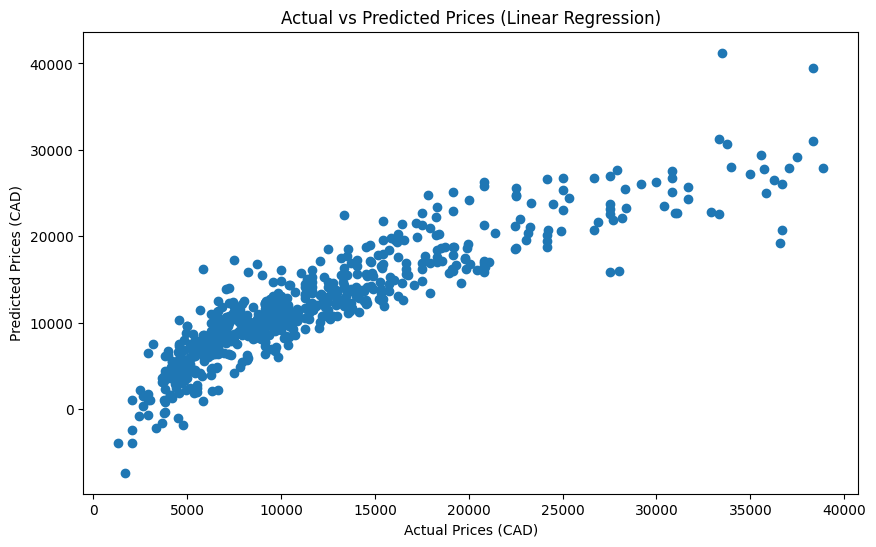

In [12]:
# Predict using Linear Regression
lr_y_pred = lr_model.predict(X_test)

# Evaluate Linear Regression
lr_mse = mean_squared_error(y_test, lr_y_pred)
lr_r2 = r2_score(y_test, lr_y_pred)

print(f'Linear Regression - MSE: {lr_mse}, R^2: {lr_r2}')

# Visualize the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, lr_y_pred)
plt.xlabel('Actual Prices (CAD)')
plt.ylabel('Predicted Prices (CAD)')
plt.title('Actual vs Predicted Prices (Linear Regression)')

#### 7.2 Random Forest Regression

##### 7.2.1 Training

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# Initialize the RandomForestRegressor
rf_model = RandomForestRegressor(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

##### 7.2.2 Model Evaluation

Random Forest - MSE: 4775088.94397821, R^2: 0.9108714260108404


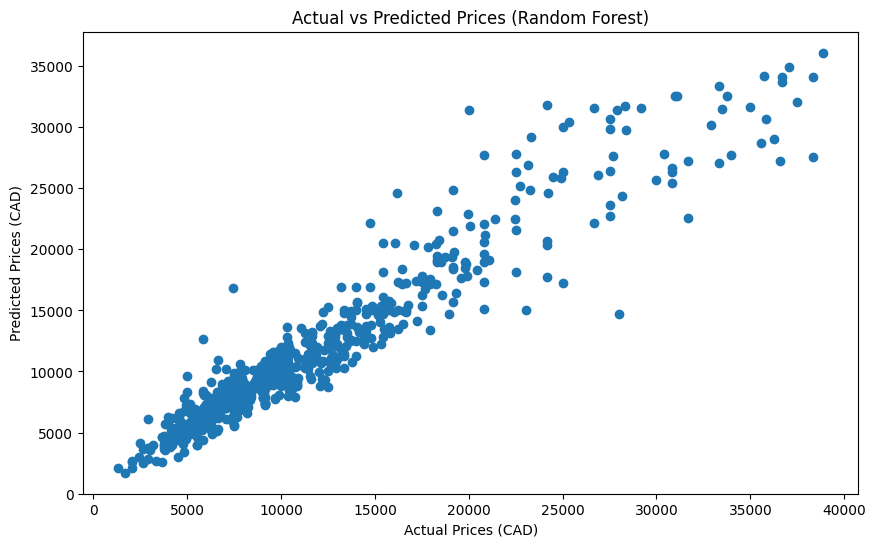

In [14]:
# Predict on the test set
rf_y_pred = rf_model.predict(X_test)

# Calculate the mean squared error and R^2 score
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_r2 = r2_score(y_test, rf_y_pred)

print(f'Random Forest - MSE: {rf_mse}, R^2: {rf_r2}')

# Visualize the actual vs predicted prices
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred)
plt.xlabel('Actual Prices (CAD)')
plt.ylabel('Predicted Prices (CAD)')
plt.title('Actual vs Predicted Prices (Random Forest)')
plt.show()


#### 7.3 DNN

##### 7.3.1 Training

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Build and train DNN model
def create_dnn_model(input_dim):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1))  # Output layer for regression
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

dnn_model = create_dnn_model(X_train.shape[1])
dnn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

c:\Users\flag8\Work\CSCN8010\venv\tensorflow_cpu\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### 7.3.2 Model Evaluation

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step
DNN - MSE: 9606247.546080895, R^2: 0.8206962937834313


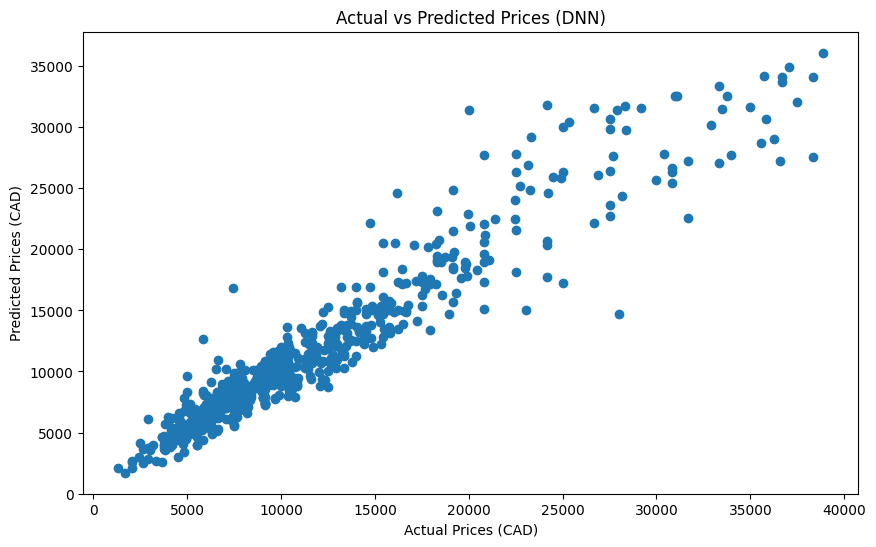

In [17]:
# Predict using DNN
dnn_y_pred = dnn_model.predict(X_test)

# Evaluate DNN
dnn_mse = mean_squared_error(y_test, dnn_y_pred)
dnn_r2 = r2_score(y_test, dnn_y_pred)

print(f'DNN - MSE: {dnn_mse}, R^2: {dnn_r2}')

# Visualize the actual vs predicted prices for Random Forest
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred)
plt.xlabel('Actual Prices (CAD)')
plt.ylabel('Predicted Prices (CAD)')
plt.title('Actual vs Predicted Prices (DNN)')
plt.show()

#### 7.4 XGBoost

##### 7.4.1 Training

In [20]:
import xgboost as xgb

# Train XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

##### 7.4.2 Model Evaluation

XGBoost - MSE: 4396489.735013501, R^2: 0.9179381022558981
Mean Squared Error (XGBoost): 4396489.735013501
R^2 Score (XGBoost): 0.9179381022558981


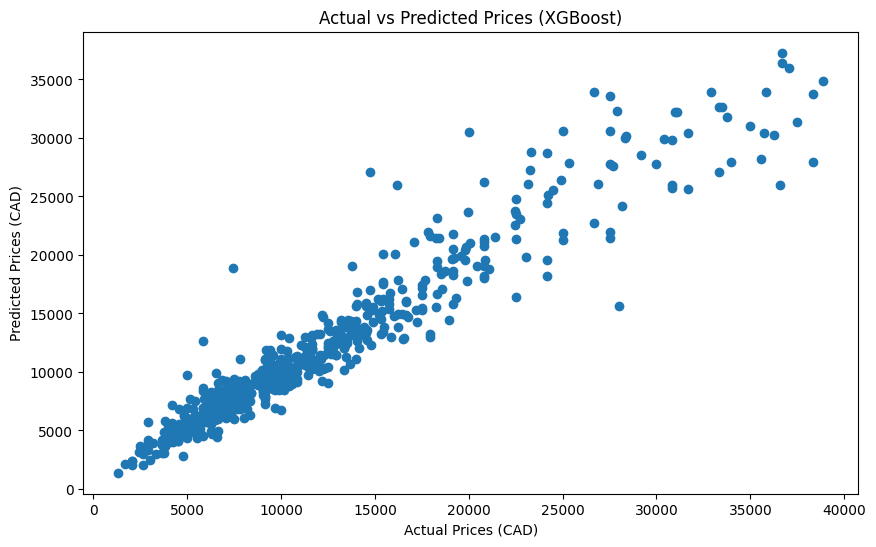

In [21]:
# Predict using XGBoost
xgb_y_pred = xgb_model.predict(X_test)

# Evaluate XGBoost
xgb_mse = mean_squared_error(y_test, xgb_y_pred)
xgb_r2 = r2_score(y_test, xgb_y_pred)

print(f'XGBoost - MSE: {xgb_mse}, R^2: {xgb_r2}')

print(f'Mean Squared Error (XGBoost): {xgb_mse}')
print(f'R^2 Score (XGBoost): {xgb_r2}')

# Visualize the actual vs predicted prices for XGBoost
plt.figure(figsize=(10, 6))
plt.scatter(y_test, xgb_y_pred)
plt.xlabel('Actual Prices (CAD)')
plt.ylabel('Predicted Prices (CAD)')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.show()

#### 7.5 Summary

In [22]:
# Summarize the results
results = {
    "Model": ["Linear Regression", "Random Forest", "DNN", "XGBoost"],
    "MSE": [lr_mse, rf_mse, dnn_mse, xgb_mse],
    "R2 Score": [lr_r2, rf_r2, dnn_r2, xgb_r2]
}

results_df = pd.DataFrame(results)

# Rank the models by performance (lower MSE is better)
results_df['Rank'] = results_df['MSE'].rank(method='min')
results_df = results_df.sort_values('Rank')

# Display the results
results_df

,Model,MSE,R2 Score,Rank
3,XGBoost,4.396490e+06,0.917938,1.0
1,Random Forest,4.775089e+06,0.910871,2.0
2,DNN,9.606248e+06,0.820696,3.0
0,Linear Regression,1.037255e+07,0.806393,4.0
